In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Runs multiple output commands in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from sklearn.preprocessing import LabelEncoder

In [67]:
%run -i 'DataLoader.py'

In [5]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [68]:
train = train[train.item_price<100000]
train = train[train.item_price>0]
train = train[train.item_cnt_day<999]

In [69]:
# Some shop names are duplicate

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [70]:
train['item_cnt_day'] = train['item_cnt_day'].clip(0,20)

In [71]:
# Adding revenue now as it will be lost later when merged into monthly data
train['daily_revenue'] = train['item_price'] * train['item_cnt_day']

In [72]:
# Features to be extracted from date
train['date']=pd.to_datetime(train['date'],format="%d.%m.%Y")
train['month']=train['date'].dt.strftime("%m");
train['month']=train['month'].astype('int64');
train['year']=train['date'].dt.strftime("%Y");
train['year']=train['year'].astype('int64');
train['days_in_month'] = train['date'].dt.days_in_month
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,daily_revenue,month,year,days_in_month
0,2013-01-02,0,59,22154,999.00,1.0,999.00,1,2013,31
1,2013-01-03,0,25,2552,899.00,1.0,899.00,1,2013,31
2,2013-01-05,0,25,2552,899.00,0.0,0.00,1,2013,31
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,1,2013,31
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,1,2013,31
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,299.00,10,2015,31
2935845,2015-10-09,33,25,7460,299.00,1.0,299.00,10,2015,31
2935846,2015-10-14,33,25,7459,349.00,1.0,349.00,10,2015,31
2935847,2015-10-22,33,25,7440,299.00,1.0,299.00,10,2015,31


In [73]:
# Grouping train data into monthly data
monthly_data = train.groupby(['shop_id','item_id','date_block_num']).agg({'item_cnt_day':'sum','item_price':'mean','daily_revenue':'mean','month':'mean','year':'mean','days_in_month':'mean'}).reset_index(); # groupby automatically removes the column not mentioned, reset_index doesn't make the groupby columns as index
# monthly_data = monthly_data.rename(columns={'date_block_num':'month_block_num','item_price':'mean_item_price','item_cnt_day':'item_cnt_month','daily_revenue':'monthly_revenue'});

In [74]:
monthly_data['item_cnt_day'] = monthly_data['item_cnt_day'].clip(0,20)
monthly_data

,shop_id,item_id,date_block_num,item_cnt_day,item_price,daily_revenue,month,year,days_in_month
0,2,27,0,1.0,2499.0,2499.0,1,2013,31
1,2,27,17,1.0,498.0,498.0,6,2014,30
2,2,30,2,1.0,359.0,359.0,3,2013,31
3,2,30,5,1.0,399.0,399.0,6,2013,30
4,2,30,15,1.0,169.0,169.0,4,2014,30
...,...,...,...,...,...,...,...,...,...
1609117,59,22164,27,2.0,699.0,699.0,4,2015,30
1609118,59,22164,30,1.0,699.0,699.0,7,2015,31
1609119,59,22167,9,1.0,299.0,299.0,10,2013,31
1609120,59,22167,11,2.0,299.0,299.0,12,2013,31


In [14]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [75]:
# We create test points in the train data set
date_block_df = pd.DataFrame(list(range(34)),columns=['date_block_num']);
date_block_df['month'] = date_block_df['date_block_num']%12+1
date_block_df['year'] = 2013+date_block_df['date_block_num']//12
month_days = pd.Series([0,31,28,31,30,31,30,31,31,30,31,30,31]);
date_block_df['days_in_month'] = date_block_df['month'].map(month_days)

date_block_df['key']=0;
test_copy = test.copy();
test_copy['key']=0;
test_copy = test_copy.merge(date_block_df);  # creates a cartesian product of all (shop, item) pairs in test will all date_block_num values
test_copy = test_copy.drop(['key'],axis=1);
test_copy

,ID,shop_id,item_id,date_block_num,month,year,days_in_month
0,0,5,5037,0,1,2013,31
1,0,5,5037,1,2,2013,28
2,0,5,5037,2,3,2013,31
3,0,5,5037,3,4,2013,30
4,0,5,5037,4,5,2013,31
...,...,...,...,...,...,...,...
7282795,214199,45,969,29,6,2015,30
7282796,214199,45,969,30,7,2015,31
7282797,214199,45,969,31,8,2015,31
7282798,214199,45,969,32,9,2015,30


In [79]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,daily_revenue,month,year,days_in_month
0,2013-01-02,0,59,22154,999.00,1.0,999.00,1,2013,31
1,2013-01-03,0,25,2552,899.00,1.0,899.00,1,2013,31
2,2013-01-05,0,25,2552,899.00,0.0,0.00,1,2013,31
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,1,2013,31
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,1,2013,31
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,299.00,10,2015,31
2935845,2015-10-09,33,25,7460,299.00,1.0,299.00,10,2015,31
2935846,2015-10-14,33,25,7459,349.00,1.0,349.00,10,2015,31
2935847,2015-10-22,33,25,7440,299.00,1.0,299.00,10,2015,31


In [16]:
# Merging this in train
monthly_data = pd.merge(test_copy,monthly_data,on=['shop_id','item_id','date_block_num','month','year','days_in_month'],how='left') 
monthly_data

,ID,shop_id,item_id,date_block_num,month,year,days_in_month,item_cnt_day,item_price,daily_revenue
0,0,5,5037,0,1,2013,31,NaN,NaN,NaN
1,0,5,5037,1,2,2013,28,NaN,NaN,NaN
2,0,5,5037,2,3,2013,31,NaN,NaN,NaN
3,0,5,5037,3,4,2013,30,NaN,NaN,NaN
4,0,5,5037,4,5,2013,31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7282795,214199,45,969,29,6,2015,30,NaN,NaN,NaN
7282796,214199,45,969,30,7,2015,31,NaN,NaN,NaN
7282797,214199,45,969,31,8,2015,31,NaN,NaN,NaN
7282798,214199,45,969,32,9,2015,30,NaN,NaN,NaN


In [17]:
# Making test like train and adding -1 to the columns that will be deleted later
# test = test.drop(['ID'],axis=1)
test['date_block_num'] = 34;
test['item_cnt_day'] = -1;
test['item_price'] = -1;
test['daily_revenue'] = -1;
test['month'] = 11
test['year'] = 2015
test['days_in_month'] = 31
test

,ID,shop_id,item_id,date_block_num,item_cnt_day,item_price,daily_revenue,month,year,days_in_month
0,0,5,5037,34,-1,-1,-1,11,2015,31
1,1,5,5320,34,-1,-1,-1,11,2015,31
2,2,5,5233,34,-1,-1,-1,11,2015,31
3,3,5,5232,34,-1,-1,-1,11,2015,31
4,4,5,5268,34,-1,-1,-1,11,2015,31
...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,-1,-1,-1,11,2015,31
214196,214196,45,16188,34,-1,-1,-1,11,2015,31
214197,214197,45,15757,34,-1,-1,-1,11,2015,31
214198,214198,45,19648,34,-1,-1,-1,11,2015,31


In [18]:
copy1 = monthly_data.copy()

In [19]:
monthly_data = pd.concat([monthly_data, test], ignore_index=True, sort=False)

In [20]:
monthly_data

,ID,shop_id,item_id,date_block_num,month,year,days_in_month,item_cnt_day,item_price,daily_revenue
0,0,5,5037,0,1,2013,31,NaN,NaN,NaN
1,0,5,5037,1,2,2013,28,NaN,NaN,NaN
2,0,5,5037,2,3,2013,31,NaN,NaN,NaN
3,0,5,5037,3,4,2013,30,NaN,NaN,NaN
4,0,5,5037,4,5,2013,31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7496995,214195,45,18454,34,11,2015,31,-1.0,-1.0,-1.0
7496996,214196,45,16188,34,11,2015,31,-1.0,-1.0,-1.0
7496997,214197,45,15757,34,11,2015,31,-1.0,-1.0,-1.0
7496998,214198,45,19648,34,11,2015,31,-1.0,-1.0,-1.0


In [21]:
# Text features

categories_translated['category_type'] = categories_translated['item_category_name_translated'].map(lambda x: x.split(' - ')[0])
categories_translated['category_sub-type'] = categories_translated['item_category_name_translated'].map(lambda x: x.split(' - ')[len(x.split(' - '))-1])

categories_translated['category_type_encoded'] = LabelEncoder().fit_transform(categories_translated['category_type'])
categories_translated['category_sub-type_encoded'] = LabelEncoder().fit_transform(categories_translated['category_sub-type'])

shops_translated['shop_city'] = shops_translated['shop_name_translated'].map(lambda x: x.split(' ')[0])
shops_translated['shop_city_encoded'] = LabelEncoder().fit_transform(shops_translated['shop_city'])

shops_translated['shop_category'] = shops_translated['shop_name_translated'].map(lambda x: x.split(' ')[1])
shops_translated['shop_category_encoded'] = LabelEncoder().fit_transform(shops_translated['shop_category'])


from sklearn.feature_extraction.text import TfidfVectorizer

items_translated = pd.merge(items,items_translated,on=['item_id'],how='inner')

tfidf = TfidfVectorizer(max_features=25)
item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_translated['item_name_translated']).toarray())
for i in range(25):
    items_translated['item_name_tfidf_' + str(i+1)] = item_name_text_features[i]

In [22]:
# Merging files
monthly_data = pd.merge(monthly_data,items_translated,on=['item_id'],how='inner')
monthly_data = pd.merge(monthly_data,categories_translated,on=['item_category_id'],how='inner')
monthly_data = pd.merge(monthly_data,shops_translated,on=['shop_id'],how='inner')

monthly_data.head()

,ID,shop_id,item_id,date_block_num,month,year,days_in_month,item_cnt_day,item_price,daily_revenue,...,item_category_name_translated,category_type,category_sub-type,category_type_encoded,category_sub-type_encoded,shop_name_translated,shop_city,shop_city_encoded,shop_category,shop_category_encoded
0,0,5,5037,0,1,2013,31,NaN,NaN,NaN,...,Games - PS3,Games,PS3,9,47,"Vologda Shopping and Entertainment Center ""Mar...",Vologda,27,Shopping,10
1,0,5,5037,1,2,2013,28,NaN,NaN,NaN,...,Games - PS3,Games,PS3,9,47,"Vologda Shopping and Entertainment Center ""Mar...",Vologda,27,Shopping,10
2,0,5,5037,2,3,2013,31,NaN,NaN,NaN,...,Games - PS3,Games,PS3,9,47,"Vologda Shopping and Entertainment Center ""Mar...",Vologda,27,Shopping,10
3,0,5,5037,3,4,2013,30,NaN,NaN,NaN,...,Games - PS3,Games,PS3,9,47,"Vologda Shopping and Entertainment Center ""Mar...",Vologda,27,Shopping,10
4,0,5,5037,4,5,2013,31,NaN,NaN,NaN,...,Games - PS3,Games,PS3,9,47,"Vologda Shopping and Entertainment Center ""Mar...",Vologda,27,Shopping,10


In [23]:
copy2 = monthly_data.copy()

In [24]:
# Calculating Lagged features

def calculate_lag(lag,monthly_data,col):
    l=monthly_data.copy()
    l['date_block_num'] += lag
    l = l[['shop_id','item_id','date_block_num',col]]
    l = l.rename(columns={col:col+'_lag'+str(lag)});
    monthly_data = pd.merge(monthly_data,l,on=['shop_id','item_id','date_block_num'],how='left')
    return monthly_data

In [25]:
# Calculating Mean encoded features

def create_mean_features(train,monthly_data,groupby_cols,col_to_avg,new_col_name):
    cur_group = train.groupby(groupby_cols).agg({col_to_avg:'mean'}).reset_index();
    cur_group = cur_group.rename(columns={col_to_avg:new_col_name});
    monthly_data = pd.merge(monthly_data,cur_group, on = groupby_cols,how = 'left');
    return monthly_data

In [26]:
lag_window = 3;
for i in ['item_cnt_day','item_price','daily_revenue']:
    for j in range(0,lag_window):
        monthly_data = calculate_lag(j+1,monthly_data,i)
        
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 0 to 7496999
Data columns (total 57 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   ID                             int64  
 1   shop_id                        int64  
 2   item_id                        int64  
 3   date_block_num                 int64  
 4   month                          int64  
 5   year                           int64  
 6   days_in_month                  int64  
 7   item_cnt_day                   float64
 8   item_price                     float64
 9   daily_revenue                  float64
 10  item_name                      object 
 11  item_category_id               int64  
 12  item_name_translated           object 
 13  item_name_tfidf_1              float64
 14  item_name_tfidf_2              float64
 15  item_name_tfidf_3              float64
 16  item_name_tfidf_4              float64
 17  item_name_tfidf_5              float64
 18  it

In [27]:
# Adding data to train to be used in calculating mean encoded features later
train = pd.merge(train,items,on=['item_id'],how='inner')
train = pd.merge(train,categories_translated,on=['item_category_id'],how='inner')
train = pd.merge(train,shops_translated,on=['shop_id'],how='inner')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,daily_revenue,month,year,days_in_month,...,item_category_name_translated,category_type,category_sub-type,category_type_encoded,category_sub-type_encoded,shop_name_translated,shop_city,shop_city_encoded,shop_category,shop_category_encoded
0,2013-01-02,0,59,22154,999.0,1.0,999.0,1,2013,31,...,Cinema - Blu-Ray,Cinema,Blu-Ray,3,9,"Yaroslavl Shopping center ""Altair""",Yaroslavl,31,Shopping,10
1,2013-04-26,3,59,944,150.0,1.0,150.0,4,2013,30,...,Cinema - Blu-Ray,Cinema,Blu-Ray,3,9,"Yaroslavl Shopping center ""Altair""",Yaroslavl,31,Shopping,10
2,2013-06-26,5,59,944,199.5,1.0,199.5,6,2013,30,...,Cinema - Blu-Ray,Cinema,Blu-Ray,3,9,"Yaroslavl Shopping center ""Altair""",Yaroslavl,31,Shopping,10
3,2013-07-20,6,59,944,199.5,1.0,199.5,7,2013,31,...,Cinema - Blu-Ray,Cinema,Blu-Ray,3,9,"Yaroslavl Shopping center ""Altair""",Yaroslavl,31,Shopping,10
4,2013-09-14,8,59,944,299.0,2.0,598.0,9,2013,30,...,Cinema - Blu-Ray,Cinema,Blu-Ray,3,9,"Yaroslavl Shopping center ""Altair""",Yaroslavl,31,Shopping,10


In [28]:
# Mean encoded features

# Average of overall items sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num'],'item_cnt_day','item_cnt_avg_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_month')
# Average of overall items per item sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','item_id'],'item_cnt_day','item_cnt_avg_item_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_item_month')
# Average of overall items per shop sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','shop_id'],'item_cnt_day','item_cnt_avg_shop_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_shop_month')
# Average of overall items per category sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','item_category_id'],'item_cnt_day','item_cnt_avg_category_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_category_month')
# Average of overall items per category type sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','category_type'],'item_cnt_day','item_cnt_avg_categorytype_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_categorytype_month')
# Average of overall items per category subtype sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','category_sub-type'],'item_cnt_day','item_cnt_avg_categorysubtype_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_categorysubtype_month')
# Average of overall items per shop city sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','shop_city'],'item_cnt_day','item_cnt_avg_shopcity_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_shopcity_month')

# Average of overall items per shop per item sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','shop_id','item_id'],'item_cnt_day','item_cnt_avg_shopitem_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_shopitem_month')
# Average of overall items per shop city per item sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','shop_city','item_id'],'item_cnt_day','item_cnt_avg_shopcityitem_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_shopcityitem_month')
# Average of overall items per shop cuty per item category type sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','shop_city','category_type'],'item_cnt_day','item_cnt_avg_shopcitytype_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_shopcitytype_month')
# Average of overall items per shop cuty per item category sub-type sold in a month
monthly_data = create_mean_features(train,monthly_data,['date_block_num','shop_city','category_sub-type'],'item_cnt_day','item_cnt_avg_shopcitysubtype_month')
monthly_data = calculate_lag(1,monthly_data,'item_cnt_avg_shopcitysubtype_month')


monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 0 to 7496999
Data columns (total 79 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   ID                                       int64  
 1   shop_id                                  int64  
 2   item_id                                  int64  
 3   date_block_num                           int64  
 4   month                                    int64  
 5   year                                     int64  
 6   days_in_month                            int64  
 7   item_cnt_day                             float64
 8   item_price                               float64
 9   daily_revenue                            float64
 10  item_name                                object 
 11  item_category_id                         int64  
 12  item_name_translated                     object 
 13  item_name_tfidf_1                        float64
 14  item_name_tfidf_2 

In [29]:
lag_window2 = 3;
# Creating trend features

# delta price
monthly_data = create_mean_features(train,monthly_data,['item_id'],'item_price','item_avg_price')
monthly_data = create_mean_features(train,monthly_data,['item_id','date_block_num'],'item_price','item_monthly_avg_price')
for j in range(0,lag_window2):
    monthly_data = calculate_lag(j+1,monthly_data,'item_monthly_avg_price')
    monthly_data['delta_price_lag_' + str(j+1) ] = (monthly_data['item_monthly_avg_price_lag' + str(j+1)]- monthly_data['item_avg_price'] ) / monthly_data['item_avg_price']

# delta revenue
monthly_data = create_mean_features(train,monthly_data,['shop_id'],'daily_revenue','shop_avg_revenue')
monthly_data = create_mean_features(train,monthly_data,['shop_id','date_block_num'],'daily_revenue','shop_monthly_avg_revenue')
for j in range(0,lag_window2):
    monthly_data = calculate_lag(j+1,monthly_data,'shop_monthly_avg_revenue')
    monthly_data['delta_revenue_lag_' + str(j+1) ] = (monthly_data['shop_monthly_avg_revenue_lag' + str(j+1)]- monthly_data['shop_avg_revenue'] ) / monthly_data['shop_avg_revenue']

monthly_data = monthly_data.replace([np.inf, -np.inf], np.nan)


In [30]:
monthly_data.tail()

,ID,shop_id,item_id,date_block_num,month,year,days_in_month,item_cnt_day,item_price,daily_revenue,...,item_monthly_avg_price_lag3,delta_price_lag_3,shop_avg_revenue,shop_monthly_avg_revenue,shop_monthly_avg_revenue_lag1,delta_revenue_lag_1,shop_monthly_avg_revenue_lag2,delta_revenue_lag_2,shop_monthly_avg_revenue_lag3,delta_revenue_lag_3
7496995,213662,45,168,30,7,2015,31,NaN,NaN,NaN,...,NaN,NaN,1126.466615,1001.554859,1378.273504,0.223537,1420.220365,0.260774,1552.243304,0.377975
7496996,213662,45,168,31,8,2015,31,NaN,NaN,NaN,...,NaN,NaN,1126.466615,1001.911758,1001.554859,-0.110888,1378.273504,0.223537,1420.220365,0.260774
7496997,213662,45,168,32,9,2015,30,NaN,NaN,NaN,...,NaN,NaN,1126.466615,1532.841187,1001.911758,-0.110571,1001.554859,-0.110888,1378.273504,0.223537
7496998,213662,45,168,33,10,2015,31,NaN,NaN,NaN,...,NaN,NaN,1126.466615,1369.488782,1532.841187,0.360752,1001.911758,-0.110571,1001.554859,-0.110888
7496999,213662,45,168,34,11,2015,31,-1.0,-1.0,-1.0,...,NaN,NaN,1126.466615,NaN,1369.488782,0.215738,1532.841187,0.360752,1001.911758,-0.110571


In [31]:
copy3 = monthly_data.copy()

In [32]:
# #Months since last sale
monthly_data = monthly_data.sort_values(by=['shop_id','item_id','date_block_num'])
monthly_data['#months_since_last_sales'] = monthly_data['date_block_num']-monthly_data['date_block_num'].shift(1,axis=0)
monthly_data.loc[(monthly_data['shop_id']!=monthly_data['shop_id'].shift(1)) | (monthly_data['item_id']!=monthly_data['item_id'].shift(1)),'#months_since_last_sales']=0

In [33]:
monthly_data = monthly_data.sort_values(by=['ID'])
monthly_data = monthly_data.drop(columns=['ID'])

In [34]:
copy4 = monthly_data.copy()

In [35]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 16 to 7421449
Data columns (total 95 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   shop_id                                  int64  
 1   item_id                                  int64  
 2   date_block_num                           int64  
 3   month                                    int64  
 4   year                                     int64  
 5   days_in_month                            int64  
 6   item_cnt_day                             float64
 7   item_price                               float64
 8   daily_revenue                            float64
 9   item_name                                object 
 10  item_category_id                         int64  
 11  item_name_translated                     object 
 12  item_name_tfidf_1                        float64
 13  item_name_tfidf_2                        float64
 14  item_name_tfidf_3

In [42]:
# Dropping lag window values
# learning_data = monthly_data[monthly_data['date_block_num'] < lag_window]

# Not dropping lagged values gives better result
learning_data = monthly_data

# Features to delete
features_to_drop = ['item_price','daily_revenue','item_name','item_category_name_translated','item_name_translated','category_type','category_sub-type','shop_name_translated','shop_city','shop_category','item_cnt_avg_month','item_cnt_avg_item_month','item_cnt_avg_shop_month','item_cnt_avg_category_month','item_cnt_avg_categorytype_month','item_cnt_avg_categorysubtype_month','item_cnt_avg_shopcity_month','item_avg_price','item_monthly_avg_price','shop_avg_revenue','shop_monthly_avg_revenue','item_cnt_avg_shopitem_month','item_cnt_avg_shopcityitem_month','item_cnt_avg_shopcitytype_month','item_cnt_avg_shopcitysubtype_month'];
learning_data = learning_data.drop(features_to_drop, axis=1);
learning_data = learning_data.rename(columns={'item_cnt_day':'item_cnt_month'});
learning_data['item_cnt_month'] = learning_data['item_cnt_month'].clip(0,20)
learning_data.fillna(0,inplace=True)

learning_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 16 to 7421449
Data columns (total 70 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   shop_id                                  int64  
 1   item_id                                  int64  
 2   date_block_num                           int64  
 3   month                                    int64  
 4   year                                     int64  
 5   days_in_month                            int64  
 6   item_cnt_month                           float64
 7   item_category_id                         int64  
 8   item_name_tfidf_1                        float64
 9   item_name_tfidf_2                        float64
 10  item_name_tfidf_3                        float64
 11  item_name_tfidf_4                        float64
 12  item_name_tfidf_5                        float64
 13  item_name_tfidf_6                        float64
 14  item_name_tfidf_7

In [43]:
X_train = learning_data[learning_data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
Y_train = learning_data[learning_data['date_block_num'] < 33]['item_cnt_month']
X_valid = learning_data[learning_data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
Y_valid = learning_data[learning_data['date_block_num'] == 33]['item_cnt_month']
X_test = learning_data[learning_data['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

In [44]:
from xgboost import XGBRegressor

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:1.03540	validation_1-rmse:1.07364
[1]	validation_0-rmse:0.98635	validation_1-rmse:1.03582
[2]	validation_0-rmse:0.94210	validation_1-rmse:1.00481
[3]	validation_0-rmse:0.91068	validation_1-rmse:0.98010
[4]	validation_0-rmse:0.87923	validation_1-rmse:0.95943
[5]	validation_0-rmse:0.85110	validation_1-rmse:0.94313
[6]	validation_0-rmse:0.83015	validation_1-rmse:0.93006
[7]	validation_0-rmse:0.81260	validation_1-rmse:0.91956
[8]	validation_0-rmse:0.79511	validation_1-rmse:0.91044
[9]	validation_0-rmse:0.78181	validation_1-rmse:0.90486
[10]	validation_0-rmse:0.77003	validation_1-rmse:0.89929
[11]	validation_0-rmse:0.75998	validation_1-rmse:0.89522
[12]	validation_0-rmse:0.75156	validation_1-rmse:0.89225
[13]	validation_0-rmse:0.74257	validation_1-rmse:0.88985
[14]	validation_0-rmse:0.73543	validation_1-rmse:0.88757
[15]	validation_0-rmse:0.73003	validation_1-rmse:0.88606
[16]	validation_0-rmse:0.72473	validation_1-rmse:0.88487
[17]	validation_0-rmse:0.72021	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [45]:
predictions = model.predict(X_test)
submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': predictions})
submission['item_cnt_month'] = submission['item_cnt_month'].clip(0,20)
submission.to_csv('xgb_trend_lag'+str(lag_window)+'.csv',index=False) 

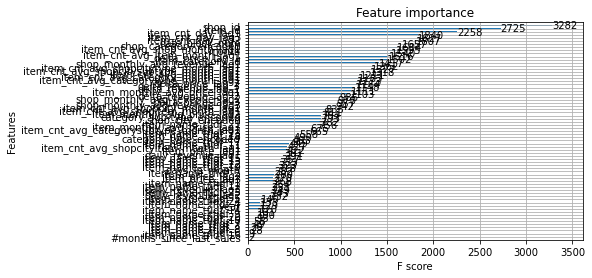

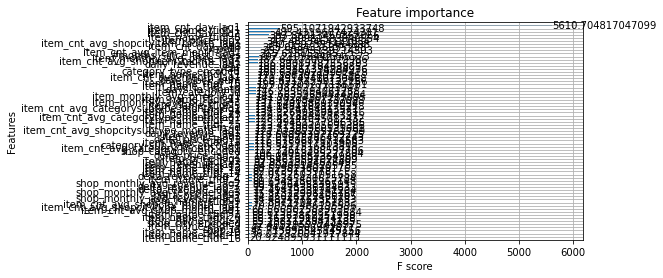

In [46]:
import xgboost as xgb
xgb.plot_importance(model);
xgb.plot_importance(model,importance_type="gain");

In [47]:
feature_importances = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type='weight'), orient='index', columns=['value'])
feature_importances = feature_importances.sort_values(by='value', ascending=False)
features_to_optimize = list(feature_importances.index)

In [55]:
from catboost import CatBoostRegressor
catmodel = CatBoostRegressor(loss_function='RMSE', iterations=400,random_seed=1,learning_rate=0.1, depth=8, l2_leaf_reg=8,one_hot_max_size=200, min_data_in_leaf = 2,bagging_temperature= 0.3,border_count=250,max_ctr_complexity=3,verbose=0)
catmodel.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True, early_stopping_rounds = 10)

0:	learn: 1.0023025	test: 1.0023025	test1: 1.0572327	best: 1.0572327 (0)	total: 756ms	remaining: 5m 1s
1:	learn: 0.9651850	test: 0.9651850	test1: 1.0270941	best: 1.0270941 (1)	total: 1.43s	remaining: 4m 45s
2:	learn: 0.9335992	test: 0.9335992	test1: 1.0028017	best: 1.0028017 (2)	total: 2.1s	remaining: 4m 38s
3:	learn: 0.9065780	test: 0.9065780	test1: 0.9823260	best: 0.9823260 (3)	total: 2.79s	remaining: 4m 35s
4:	learn: 0.8840020	test: 0.8840020	test1: 0.9649429	best: 0.9649429 (4)	total: 3.5s	remaining: 4m 36s
5:	learn: 0.8647206	test: 0.8647206	test1: 0.9511383	best: 0.9511383 (5)	total: 4.34s	remaining: 4m 44s
6:	learn: 0.8482784	test: 0.8482784	test1: 0.9389768	best: 0.9389768 (6)	total: 5.1s	remaining: 4m 46s
7:	learn: 0.8345513	test: 0.8345513	test1: 0.9303246	best: 0.9303246 (7)	total: 5.75s	remaining: 4m 41s
8:	learn: 0.8227508	test: 0.8227508	test1: 0.9239423	best: 0.9239423 (8)	total: 6.47s	remaining: 4m 41s
9:	learn: 0.8129295	test: 0.8129295	test1: 0.9188865	best: 0.9188865

In [56]:
predictions = catmodel.predict(X_test)
submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': predictions})
submission['item_cnt_month'] = submission['item_cnt_month'].clip(0,20)
submission.to_csv('xgb_trend_lag'+str(lag_window)+'.csv',index=False) 